# 3.4 Shrinkage Methods

By retaining a subset of the predictors and discarding the rest, subset selection produces a model that is interpretable and has possibly lower prediction error than the full model. However, because it is a discrete process— variables are either retained or discarded—it often exhibits high variance, and so doesn’t reduce the prediction error of the full model. Shrinkage methods are more continuous, and don’t suffer as much from high variability.

In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns 
import matplotlib.pyplot as plt
from ch3 import LinearRegression, SVD
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_formats = ['svg']

## 3.4.1 Ridge Regression

Ridge regression shrinks the regression coefficients by imposing a penalty on their size. The ridge coefficients minimize a penalized residual sum of squares,

\begin{equation}
\hat\beta^{\text{ridge}} = {\arg\min}_{\beta}\left\lbrace \sum_{i=1}^N\left( y_i - \beta_0 - \sum_{j=1}^p x_{ij}\beta_j \right)^2 +\lambda\sum_{j=1}^p \beta_j^2 \right\rbrace,
\end{equation}

where $\lambda \ge 0$ is a complexity parameter that controls the amount of shrinkage: the larger the $\lambda$, the greater the amount of shrinkage. The idea of penalizing by the sum-of-squares of the parameters is also used in neural networks, a.k.a. *weight decay* (Chapter 11).

An equivalent way to write the ridge problem is to make explicit the size constraint on the parameters, as


\begin{equation}
\begin{aligned}
\hat\beta^{\text{ridge}} & = {\arg\min}_\beta \sum_{i=1}^N \left( y_i - \beta_0 - \sum_{j=1}^p x_{ij}\beta_j \right)^2 \\ 
& \text{ subject to } \sum_{j=1}^p \beta_j^2 \le t,
\end{aligned}
\end{equation}



where $t$ has a one-to-one correspondence with $\lambda$.

When there are many correlated variables in a linear regression model, their coefficients can become poorly determined and exhibit high variance. A wildly large positive coefficient on one variable can be canceled by a similarly large negative coefficient on its correlated cousin. By imposing a size constraint on the coefficients, this problem is alleviated.


### Scaling and centering

The ridge solutions are not equivariant (not comparable)under scaling of the inputs, and so  one normally standardizes the inputs before solving the ridge problem.

Also notice that the intercept $\beta_0$ has been left out of the penalty term. Penalization of the intercept would make the procedure depend on the origin chosen for $Y$; i.e., adding a constant $c$ to each of the targets $y_i$ (i.e. simply shifting) would not simply result in a shift of the predictions by the same constant $c$.

It can be shown that the ridge solution can be separated into two parts, after reparametrization using *centered* inputs: Each $x_{ij}$ gets replaced by $x_{ij}-\bar{x}_j$.
1. We estimate $\beta_0$ by the mean response $\bar{y} = \frac{1}{N}\sum_1^N y_i$.
2. The remaining coefficients get estimated by a ridge regression without intercept, using centered $x_{ij}$.

Henceforth we assume that this centering has been done, so that the input matrix $\mathbf{X}$ has $p$ columns rather than $p+1$.

### Matrix form

The equation (1) could be written in the following matrix form: 

\begin{equation}
\text{RSS}(\lambda) = (\mathbf{y}-\mathbf{X}\beta)^T(\mathbf{y}-\mathbf{X}\beta) + \lambda\beta^T\beta
\end{equation}

The ridge regression solutions are easily seen to be

\begin{equation}
\hat\beta^{\text{ridge}} = \left( \mathbf{X}^T\mathbf{X} + \lambda\mathbf{I} \right)^{-1}\mathbf{X}^T\mathbf{y},
\end{equation}

where $\mathbf{I}$ is the $p\times p$ identity matrix. Notice that the ridge solution is again a linear function of $\mathbf{y}$ by the choice of quadratic penalty $\beta^T\beta$, resulting in addition of a positive constant to the diagonal of $\mathbf{X}^T\mathbf{X}$ before inversion. _This makes the problem nonsingular, even if $\mathbf{X}^T\mathbf{X}$ is not of full rank_. It was actually the main motivation for ridge regression when it was first introduced in statistics (Hoerl and Kennard, 1970).

__Remark__: It is all about penalty. In equation (1), the
penalty was added via $\lambda$ that corresponds to $t$ in equation (2) one-to-one. Therefore, our new `OLS` estimation should have an additional parameter. 

In [6]:
def ridge_regression(X :np.ndarray, Y :np.ndarray, lam :float) -> np.ndarray:
    """
    Y need to be centered by subtracting the mean \\
    beta_intercept = Y.mean() \\ 
    X need to be normalized \\ 
    lam: value of lambda  \\
    The coefficients could be estimated via equation (4) \\
    See equation (6) for the derivation
    """
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    d = s / (s[:, np.newaxis].T ** 2 + lam[:, np.newaxis])
    Uy = U.T.dot(Y)
    coefs = np.dot(d * U.T.dot(Y), Vt)
    
    return coefs 

## Regression and SVD

The SVD of the centered input matrix $\mathbf{X}$ gives us some additional insight into the nature of ridge regression. The SVD of the $N\times p$ matrix $\mathbf{X}$ has the form

\begin{equation}
\mathbf{X} = \mathbf{U\Sigma V}^T,
\end{equation}

where
* $\mathbf{U}$ is $N\times p$ orthogonal matrix, with the columns of $\mathbf{U}$ spanning the $\text{col}(\mathbf{X})$, and $U^TU = I$
* $\mathbf{V}$ is $p\times p$ orthogonal matrix, with the columns of $\mathbf{V}$ spanning the $\text{row}(\mathbf{X})$, and $VV^T = I$
* $\mathbf{\Sigma}$ is a $p\times p$ diagonal matrix, with diagonal entries  
$d_1 \ge d_2 \ge \cdots \ge d_p \ge 0$ called the singular values of $\mathbf{X}$.
* If one or more values $d_j = 0$, $\mathbf{X}$ is singular.

we have derived the following formula:

\begin{equation*}
\hat\beta^{\text{ridge}} = \left( \mathbf{X}^T\mathbf{X} + \lambda\mathbf{I} \right)^{-1}\mathbf{X}^T\mathbf{y},
\end{equation*}

Now, substitute the equation (5) into the above formula, we could have the simplified estimation formula:

\begin{equation}
\begin{aligned}
\hat\beta^{\text{ridge}} & = (V \Sigma U^T U \Sigma V^T + \lambda I)^{-1} (V \Sigma U^T) y \\
& = (\Sigma^2 + \lambda I)^{-1} (V \Sigma U^T) y \\
& = V \frac{\Sigma}{\Sigma^2 + \lambda} U^T y \\
& = V \sum_j^p \frac{d_j}{d_j^2 + \lambda} U^T y 
\end{aligned}
\end{equation}

This monotone decreasing function of $\lambda$ is the *effective degrees of freedom* of the ridge regression fit. 

\begin{equation}
\begin{aligned}
\text{df}(\lambda) &= \text{tr}\left( \mathbf{X}(\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})^{-1}\mathbf{X}^T \right), \\
&= \text{tr}(\mathbf{H}_\lambda) \\
&= \sum_{j=1}^p \frac{d_j^2}{d_j^2+\lambda}.
\end{aligned}
\end{equation}

Usually in a linear-regression fit, the degrees-of-freedom of the fit is $p$, the number of free parameters. The idea is that although all $p$ coefficients in a ridge fit will be non-zero, they are fit in a restricted fashion controlled by $\lambda$. Note that

\begin{aligned}
\text{df}(\lambda) &= p \text{ when }\lambda = 0, \\
\text{df}(\lambda) &\rightarrow 0 \text{ as }\lambda \rightarrow \infty.
\end{aligned}

Using the SVD we can write the least squares fitted vector as

\begin{equation}
\begin{aligned}
\mathbf{X}\hat\beta^{\text{ls}} &= \mathbf{X}(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y} \\
&= \mathbf{UU}^T\mathbf{y}.
\end{aligned}
\end{equation}

Note
* $\mathbf{U}^T\mathbf{y}$ are the coordinates of $\mathbf{y}$ w.r.t. the orthonormal basis $\mathbf{U}$.
* the similarity with QR decomposition; $\mathbf{Q}$ and $\mathbf{U}$ are generally different orthogonal bases for $\text{col}(\mathbf{X})$.

Now the ridge solutions are

\begin{equation}
\begin{aligned}
\mathbf{X}\hat\beta^{\text{ridge}} &= \mathbf{X}(\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y} \\
&= \mathbf{U \Sigma}(\mathbf{\Sigma}^2 + \lambda\mathbf{I})^{-1}\mathbf{\Sigma U}^T\mathbf{y} \\
&= \sum_{j=1}^p \mathbf{u}_j \frac{d_j^2}{d_j^2+\lambda}\mathbf{u}_j^T\mathbf{y},
\end{aligned}
\end{equation}

where the $\mathbf{u}_j$ are the columns of $\mathbf{U}$. The ridge solution then shrinks these coordinates by the factors $d_j^2/(d_j^2+\lambda)$. This means that a greater amount of shrinkage is applied to the coordinates of basis vectors with smaller $d_j^2$. Then what does a small value of $d_j^2$ mean?

In our illustration, we have shown that the matrix $D$ scaled the unit circle. When $d_j$ is small, it means that it will scale the effect. _Since the data matrix $X$ speaks for itself, we could correspond to it by shrinking
its coefficients._

Now, we will plot the error in terms of equation (7). 

In [2]:
# load, normalize and split the dataset
lr = LinearRegression()
lr.normalize_dataset()
lr.split_dataset()

The shape of splitted dataset is: (67, 8)
The shape of splitted dataset is: (30, 8)
The shape of splitted dataset is: (67, 1)
The shape of splitted dataset is: (30, 1)


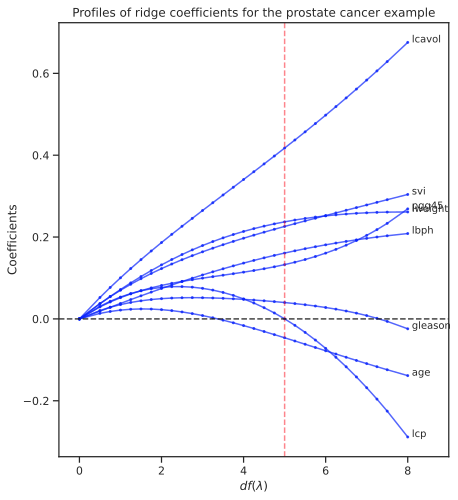

In [13]:
lr.plot_figure_3_8()

### The SVD and the principal components

The SVD of the centered matrix $\mathbf{X}$ is another way of expressing the *principal components* of the variables in $\mathbf{X}$. The sample covariance matrix is given by

\begin{equation}
\mathbf{S} = \frac{1}{N}\mathbf{X}^T\mathbf{X},
\end{equation}

and via the SVD,

\begin{equation}
\mathbf{X}^T\mathbf{X} = \mathbf{VD}^2\mathbf{V}^T,
\end{equation}

which is the *eigen decomposition* of $\mathbf{X}^T\mathbf{X}$ (and of $\mathbf{S}$, up to a factor $N$). The eigenvectors $v_j$ (columns of $\mathbf{V}$) are also called the *principal components* (or Karhunen-Loeve) directions of $\mathbf{X}$. The first principal component direction $v_1$ has the property that $\mathbf{z}_1 = \mathbf{X}v_1$ has the larger sample projected variance than any other direction. This sample variance is easily seen to be

\begin{equation}
\text{Var}(\mathbf{z}_1) = \text{Var}(\mathbf{X}v_1) = \frac{d_1^2}{N},
\end{equation}

and in fact $\mathbf{z}_1 = \mathbf{X}v_1 = \mathbf{u}_1 d_1$. The derived variable $z_1$ is called the first principal component of $\mathbf{X}$, and hence $\mathbf{u}_1$ is the normalized first principal component. And subsequent principal components $z_j$ have maximum variance $d_j^2/N$, subject to being orthogonal to the earlier ones. Conversely the last principal component has minimum variance. __Hence the small singular values $d_j$ correspond to directions in the $\text{col}(\mathbf{X})$ having small variance, and ridge regression shrinks these directions the most__. In simple words, it does not care what seems not worth. 

In [40]:
# use the full dataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
x = lr.data.iloc[:, :-2]
x_normlized = StandardScaler().fit_transform(x)
x = pd.DataFrame(x_normlized, columns=x.columns)
x.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
0,-1.645861,-2.016634,-1.872101,-1.030029,-0.525657,-0.867655,-1.047571,-0.868957
1,-1.999313,-0.725759,-0.791989,-1.030029,-0.525657,-0.867655,-1.047571,-0.868957
2,-1.587021,-2.200154,1.368234,-1.030029,-0.525657,-0.867655,0.344407,-0.156155
3,-2.178174,-0.812191,-0.791989,-1.030029,-0.525657,-0.867655,-1.047571,-0.868957
4,-0.510513,-0.461218,-0.251933,-1.030029,-0.525657,-0.867655,-1.047571,-0.868957


In [46]:
x_pca = PCA().fit(x)
# explained variance ratio
ex_var_ratio = x_pca.explained_variance_ratio_
ex_var_ratio

array([0.42009315, 0.20603829, 0.12195763, 0.07900139, 0.06041136,
       0.05527663, 0.03282798, 0.02439358])

In [61]:
x_pca.components_.shape

(8, 8)

In [62]:
# feature selection 
pca_list = ['pca'+str(i) for i in range(1, x_pca.n_components_+1)]
pca_dict = dict(zip(pca_list, x_pca.components_))
pca_df = pd.DataFrame(pca_dict)
pca_df['variable'] = x.columns
pca_df = pca_df.set_index('variable')
pca_df

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8
variable,,,,,,,,
lcavol,0.422240,-0.053699,-0.331615,-0.100634,0.405920,-0.625011,0.173497,-0.336487
lweight,0.187124,0.538773,-0.422494,0.131824,0.437879,0.532361,-0.010467,0.059783
age,0.223228,0.468632,0.242454,-0.792753,-0.142123,-0.058596,-0.113611,0.082288
lbph,0.085629,0.628869,0.083361,0.510549,-0.435756,-0.362573,0.082755,-0.037294
svi,0.390208,-0.207422,-0.395193,-0.120374,-0.583361,0.282660,0.460411,-0.043145
lcp,0.464179,-0.190083,-0.186870,0.136028,-0.120483,-0.123965,-0.632139,0.515267
gleason,0.405725,-0.071989,0.538182,0.158084,0.278604,0.049202,0.491096,0.440860
pgg45,0.444069,-0.086083,0.406275,0.159350,-0.031015,0.305576,-0.311899,-0.642901


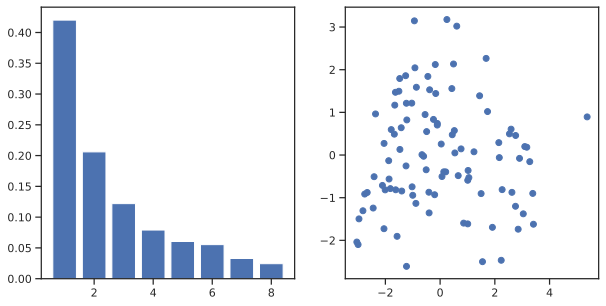

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].bar(range(1, len(ex_var_ratio)+1), ex_var_ratio)